In [2]:
# Import the datasets
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

url = 'https://raw.githubusercontent.com/GoldbergData/Machine-Learning-Book-Ratings/master/data/clean/reduced_books_users_ratings.csv'
reduced = pd.read_csv(url,index_col=0,parse_dates=[0])
reduced = pd.DataFrame(reduced)
reduced.head(2)

,isbn,book_rating,book_title,book_author,year_of_publication,publisher,unique_isbn,age,city,state,country,dropornot,dropuser
user_id,,,,,,,,,,,,,
11676,038550120X,10,A Painted House,JOHN GRISHAM,2001.0,Doubleday,038550120X,34.786876,NaN,n/a,n/a,False,False
11676,0671537458,8,Waiting to Exhale,Terry McMillan,1995.0,Pocket,0671537458,34.786876,NaN,n/a,n/a,False,False


In [3]:
# Clean the data
reduced = reduced.drop(columns =['Unnamed: 0.1'])
reduced = reduced.drop(columns =['Unnamed: 0.1.1'])
reduced.head(2)

KeyError: "['Unnamed: 0.1'] not found in axis"

In [ ]:
# Map unique IBSNs onto book titles
predct = dict(zip(reduced.unique_isbn.unique(), reduced.book_title.unique()))   

#### Basic EDA

In [ ]:
# Check how many entries per book title

#reduced['book_title'].value_counts()

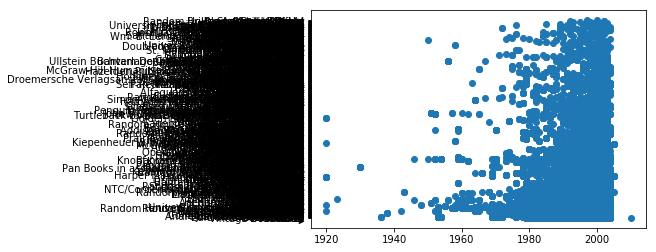

In [6]:
plt.scatter(reduced['year_of_publication'], reduced['publisher'])
plt.show()
# Most books are from 1990s

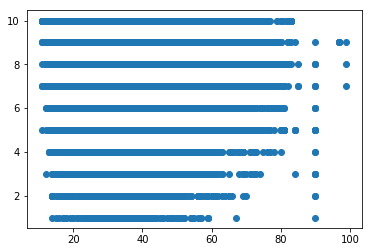

In [7]:
plt.scatter(reduced['age'], reduced['book_rating'])
plt.show()

In [4]:
# Group by book_title
# Group by book titles and create a new column for total ratings count
reduced_count = (reduced.groupby(by = ['book_title'])['book_rating'].count().reset_index().rename(columns = {'book_rating':'total_rating_count'})[['book_title','total_rating_count']])
reduced_count.head()

,book_title,total_rating_count
0,'Salem's Lot,19
1,10 Lb. Penalty,15
2,100 Selected Poems by E. E. Cummings,6
3,101 Dalmatians,9
4,"14,000 Things to Be Happy About",14


In [5]:
# Merge the columns
reduced_with_count = reduced.merge(reduced_count, left_on = 'book_title', right_on = 'book_title', how = 'left')
reduced_with_count.head(5)

,user_id,isbn,book_rating,book_title,book_author,year_of_publication,publisher,unique_isbn,age,city,state,country,dropornot,dropuser,total_rating_count
0,11676,038550120X,10,A Painted House,JOHN GRISHAM,2001.0,Doubleday,038550120X,34.786876,NaN,n/a,n/a,False,False,242
1,11676,0671537458,8,Waiting to Exhale,Terry McMillan,1995.0,Pocket,0671537458,34.786876,NaN,n/a,n/a,False,False,25
2,11676,0679776818,8,Birdsong: A Novel of Love and War,Sebastian Faulks,1997.0,Vintage Books USA,0679776818,34.786876,NaN,n/a,n/a,False,False,15
3,11676,0684867621,3,The Girl Who Loved Tom Gordon : A Novel,Stephen King,1999.0,Scribner,0684867621,34.786876,NaN,n/a,n/a,False,False,46
4,11676,8437606322,8,Anna Karenina,Leo Tolstoy,1999.0,Ediciones Catedra S.A.,8437606322,34.786876,NaN,n/a,n/a,False,False,12


In [6]:
# Drop variables non-numeric variables
reduced_with_count = reduced_with_count.drop(['isbn','book_author','book_title','publisher','age','city','state','country','dropornot','dropuser'], axis = 1)
reduced_with_count.head(5)

,user_id,book_rating,year_of_publication,unique_isbn,total_rating_count
0,11676,10,2001.0,038550120X,242
1,11676,8,1995.0,0671537458,25
2,11676,8,1997.0,0679776818,15
3,11676,3,1999.0,0684867621,46
4,11676,8,1999.0,8437606322,12


#### Trying the matrix way without splitting

In [51]:
from scipy.sparse import csr_matrix
# Drop duplicates
reduced_with_count = reduced_with_count.drop_duplicates(['user_id','book_title'])

# Run pivot
reduced_pivot = reduced_with_count.pivot(index = 'book_title', columns = 'user_id', values = 'book_rating').fillna(0)

# Create a mtrix of pivot values
reduced_matrix = csr_matrix(reduced_pivot.values)
reduced_matrix

<5584x11104 sparse matrix of type '<class 'numpy.float64'>'
	with 119226 stored elements in Compressed Sparse Row format>

#### Remove 9000+  isbn's that contain a letter

In [7]:
# Check for unqiue_isbn that have characters

#reduced_with_count.loc[reduced_with_count['unique_isbn'].str.endswith('X')]
reduced_with_count[reduced_with_count['unique_isbn'].str.endswith('X')]
reduced_with_count =reduced_with_count[~(reduced_with_count['unique_isbn'].str.endswith('X'))]

print(sum(reduced_with_count['unique_isbn'].str.endswith('X')))

#iris.ix[iris['sepal length (cm)'] >= 5]
#iris.ix[~(iris['sepal length (cm)'] < 5)]

0


In [8]:
reduced_with_count[reduced_with_count['unique_isbn'].str.endswith('x')]
reduced_with_count =reduced_with_count[~(reduced_with_count['unique_isbn'].str.endswith('x'))]
print(sum(reduced_with_count['unique_isbn'].str.endswith('x')))

0


In [9]:
predct = dict(zip(reduced_with_count.unique_isbn.unique(), reduced_with_count.book_rating.unique()))   
predct

{'0671537458': 8,
 '0679776818': 3,
 '0684867621': 9,
 '8437606322': 10,
 '3548603203': 1,
 '0440498058': 5,
 '0440225825': 7,
 '0380005239': 6,
 '3551551677': 4,
 '0836220889': 2}

#### Split the daset and declare variables

In [10]:
# Split the data into train and test
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

X = reduced_with_count.drop(['book_rating'],axis = 1)
print(X.shape)

y = reduced_with_count['book_rating']
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.30,random_state=0)

print(sum(X['unique_isbn'].str.endswith('X')))


(110522, 4)
0


In [11]:
# Look at the distribution of X_train and X_test
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(77365, 4)
(33157, 4)
(77365,)
(33157,)


In [12]:
X_train.head(2)

,user_id,year_of_publication,unique_isbn,total_rating_count
100319,122716,1993.0,0451523385,13
50231,129851,1993.0,0345384466,97


#### Use kNN Classifier to predict a new rating 
https://www.ritchieng.com/machine-learning-efficiently-search-tuning-param/

In [14]:
# Run default kNN algorithm
from sklearn.model_selection import GridSearchCV

# Base model
# metric = 'cosine', algorithm = 'brute'

# Define parameters
#param_grid = {'n_neighbors':[5, 10, 20],
#              'metric': ['cosine'],
#              'algorithm':['brute']}

knn_clf = KNeighborsClassifier()
k_range = list(range(1, 50))
print(k_range)

#predct = dict(zip(reduced.unique_isbn.unique(), reduced_with_count.book_title.unique()))   
#predct

param_grid = dict(n_neighbors=k_range)
print(param_grid)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]
{'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]}


In [15]:
grid = GridSearchCV(knn_clf, param_grid, cv=10, scoring='accuracy')

In [16]:
# fit the grid with data
grid.fit(X_train, y_train)

GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [17]:
# view the complete results (list of named tuples)
print(grid.best_params_)
print(grid.best_estimator_) # best model

{'n_neighbors': 47}
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=47, p=2,
           weights='uniform')


In [18]:
print('Parameters')
print(grid.get_params)

# Array of 10 accuracy scores during 10-fold cv using the parameters
print('')
print('CV Validation Score')
print(grid.cv_results_ )

# Mean of the 10 scores
print('')
print('Mean Validation Score')
print(grid.grid_scores_[0].mean_validation_score)

Parameters
<bound method BaseEstimator.get_params of GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)>

CV Validation Score
{'mean_fit_time': array([0.08686225, 0.08343081, 0.07644794, 0.07700782, 0.07768118,
       0.07604599, 0.07554038, 0.07690408, 0.07710061, 0.07849185,
       0.07682438, 0.07483931, 0.07609038, 0.07584369, 0.07638197,
       0.07602274, 0.07623045, 0.0767019 , 0.07624729, 0.07547824,
       0.07528725, 

AttributeError: 'GridSearchCV' object has no attribute 'grid_scores_'

In [26]:
# KNN BEST
knn_best = KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=47, p=2,
           weights='uniform')
knn_best.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=47, p=2,
           weights='uniform')

In [27]:
from sklearn.metrics import accuracy_score
knn_best_probs = knn_best.predict_proba(X_test)[:,1]
knn_best_preds = knn_best.predict(X_test)
print(accuracy_score(y_test, knn_best_preds))

0.24408118949241486


In [28]:
X_train.head(2)

,user_id,year_of_publication,unique_isbn,total_rating_count
100319,122716,1993.0,0451523385,13
50231,129851,1993.0,0345384466,97


#### Cross - Validation
https://kevinzakka.github.io/2016/07/13/k-nearest-neighbor/

In [29]:
from sklearn.model_selection import cross_val_score
# creating odd list of K for KNN
myList = list(range(1,50))

# subsetting just the odd ones
neighbors = list(filter(lambda x: x % 2 != 0, myList))

# empty list that will hold cv scores
cv_scores = []

# perform 10-fold cross validation
for k in neighbors:
    knn_clf2 = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn_clf2, X_train, y_train, cv=10, scoring='accuracy')
    cv_scores.append(scores.mean())

The optimal number of neighbors is 47


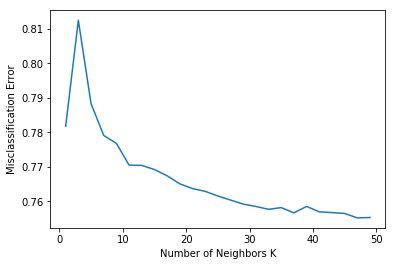

In [163]:
# changing to misclassification error
MSE = [1 - x for x in cv_scores]

# determining best k
optimal_k = neighbors[MSE.index(min(MSE))]
print("The optimal number of neighbors is %d" % optimal_k)

# plot misclassification error vs k
plt.plot(neighbors, MSE)
plt.xlabel('Number of Neighbors K')
plt.ylabel('Misclassification Error')
plt.show()

#### ! Code below does not work -- crashes kernel

In [ ]:
from matplotlib.colors import ListedColormap
from sklearn.neighbors import KNeighborsClassifier
import numpy as np
import matplotlib.pyplot as plt
import pylab as pl

h = .05 # step size in the mesh

# Initialize the best classfier 
knn_best = KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=19, p=2,
           weights='uniform')
# Fit the data
knn_best.fit(X_train, y_train)

x_min, x_max = X_train.iloc[:, 0].min() - 0.5, X_train.iloc[:, 0].max() + 0.5
y_min, y_max = X_train.iloc[:, 1].min() - 0.5, X_train.iloc[:, 1].max() + 0.5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),np.arange(y_min, y_max, h))
Z = knn_best.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
pl.figure(1, figsize=(4, 3))
pl.set_cmap(pl.cm.Paired)
pl.pcolormesh(xx, yy, Z)

# Plot also the training points
pl.scatter(X_train.iloc[:,0], X_train.iloc[:,1],c=Y )
pl.xlabel('User ID')
pl.ylabel('Year of Publication')

pl.xlim(xx.min(), xx.max())
pl.ylim(yy.min(), yy.max())
pl.xticks(())
pl.yticks(())

pl.show()